In [2]:
# %%
import pandas as pd
# Load preprocessed data
train_df = pd.read_csv("../train_data_final.csv")
test_df = pd.read_csv("../test_data_final.csv")

# %%
# Inspect the first few rows
print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())


Training Data:
                                    tokenized_review  label  \
0  ['bromwell', 'high', 'cartoon', 'comedy', 'ran...      1   
1  ['homelessness', 'houselessness', 'george', 'c...      1   
2  ['brilliant', 'overacting', 'lesley', 'ann', '...      1   
3  ['easily', 'underrated', 'film', 'inn', 'brook...      1   
4  ['typical', 'mel', 'brooks', 'film', 'slapstic...      1   

                                       padded_review  
0  [1, 1, 1810, 21419, 18612, 16148, 29213, 8241,...  
1  [1, 1, 11834, 18612, 16148, 8241, 15074, 8241,...  
2  [1, 1, 1810, 21419, 1, 15074, 15074, 1, 1, 179...  
3  [1, 1, 8241, 1, 23109, 1, 15074, 30138, 1, 1, ...  
4  [1, 1, 26604, 30138, 19313, 1, 3646, 1, 15074,...  

Test Data:
                                    tokenized_review  label  \
0  ['go', 'see', 'movie', 'night', 'coax', 'frien...      1   
1  ['actor', 'turn', 'director', 'bill', 'paxton'...      1   
2  ['recreational', 'golfer', 'knowledge', 'sport...      1   
3  ['see', '

In [40]:
import ast
train_df['list_length'] = train_df['padded_review'].apply(lambda x: len(ast.literal_eval(x)))

# Display the updated DataFrame with the list length
print(train_df[['padded_review', 'list_length']])

                                        padded_review  list_length
0   [1, 1, 19313, 1, 17974, 1, 3646, 1, 1, 1, 1, 2...         1066
1   [1, 1, 1, 23109, 14627, 1, 1, 1, 1, 1810, 8241...         1066
2   [1, 1, 1810, 1, 10753, 1, 1, 1, 1, 9415, 1, 17...         1066
3   [1, 1, 9415, 1, 17974, 1, 23109, 11834, 8241, ...         1066
4   [1, 1, 10753, 21419, 8241, 10753, 1, 1, 1, 1, ...         1066
..                                                ...          ...
95  [1, 1, 19313, 8241, 21419, 9415, 8241, 3646, 2...         1066
96  [1, 1, 29213, 18612, 21419, 6390, 1, 1, 1, 1, ...         1066
97  [1, 1, 1, 17974, 26604, 18612, 17974, 1, 18612...         1066
98  [1, 1, 15074, 18612, 29213, 8241, 23109, 26604...         1066
99  [1, 1, 16148, 18612, 28754, 1, 8241, 1, 1, 1, ...         1066

[100 rows x 2 columns]


In [47]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast  # For safely evaluating strings containing Python literals
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Define vocabulary size
vocab_size = 31000  # Original vocabulary size
# vocab_size = min(vocab_size, 2000)  # Reduce vocab size to 2000 to manage memory

def indices_to_multi_hot(indices, vocab_size):
    """
    Convert a list of indices to a multi-hot encoded vector.
    
    Args:
        indices (list): List of word indices in the review.
        vocab_size (int): Size of the vocabulary.
        
    Returns:
        torch.Tensor: Multi-hot encoded vector.
    """
    multi_hot = torch.zeros(vocab_size)
    for index in indices:
        if index < vocab_size:
            multi_hot[index] = 1
    return multi_hot

class SentimentDataset(Dataset):
    def __init__(self, dataframe, vocab_size):
        """
        Args:
            dataframe (pd.DataFrame): Dataframe containing 'padded_review' and 'label'.
            vocab_size (int): Size of the vocabulary for multi-hot encoding.
        """
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        multi_hot_encoded = indices_to_multi_hot(indices, self.vocab_size)
        label = self.labels.iloc[idx]
        return multi_hot_encoded, label

# Load your datasets
train_df = pd.read_csv('../train_data_final.csv')
test_df = pd.read_csv('../test_data_final.csv')

# Sampling 1000 examples from each dataset to manage computational resources
train_df = train_df.sample(n=1000, random_state=4).reset_index(drop=True)
test_df = test_df.sample(n=1000, random_state=4).reset_index(drop=True)
# print(train_df['padded_review'][0].shape)
# Splitting train_df into train and dev sets
train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=42)
test_data = test_df

print(train_data.shape)
# Truncate the sequences to max_length
max_length = 1066  # Truncate sequences to 180 tokens


# Apply truncation directly to the 'padded_review' column in each DataFrame
train_data['padded_review'] = train_data['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_data['padded_review'] = dev_data['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
test_data['padded_review'] = test_data['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

# Ensure labels are numeric (convert if necessary)
train_data['label'] = pd.to_numeric(train_data['label'])
dev_data['label'] = pd.to_numeric(dev_data['label'])
test_data['label'] = pd.to_numeric(test_data['label'])

# Create datasets
train_dataset = SentimentDataset(train_data, vocab_size)
dev_dataset = SentimentDataset(dev_data, vocab_size)
test_dataset = SentimentDataset(test_data, vocab_size)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print data loader counts
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")


(900, 3)
Number of batches in training loader: 29
Number of batches in dev loader: 4
Number of batches in test loader: 32


In [48]:
# Print a dataloader batch
for X_batch, y_batch in train_loader:
    print("Batch X shape:", X_batch.shape)  # Shape of the batch
    print("Batch Y shape:", y_batch.shape)  # Shape of the labels
    # Print the indices of the first sequence in the batch
    print("Indices where value is 1 in Batch X[0]:", (X_batch[0] == 1).nonzero(as_tuple=True)[0].tolist())
    print("Indices where value is 1 in Batch X[0]:", (X_batch[1] == 1).nonzero(as_tuple=True)[0].tolist())
    # print("Batch X content:\n", X_batch[31,:100])    # Content of one-hot encoded vectors
    print("Batch Y content:", y_batch)      # Content of labels
    break  # Break after printing the first batch to avoid printing multiple batches

Batch X shape: torch.Size([32, 31000])
Batch Y shape: torch.Size([32])
Indices where value is 1 in Batch X[0]: [1, 1810, 3646, 6390, 8241, 9415, 10753, 11834, 14627, 15074, 16148, 17974, 18612, 19313, 21328, 21419, 23109, 26604, 28132, 28754, 29213, 30123, 30138]
Indices where value is 1 in Batch X[0]: [0, 1, 1810, 3646, 6390, 8241, 9415, 10753, 11834, 14199, 14627, 15074, 16148, 17974, 18612, 19313, 21419, 23109, 26604, 28132, 28754, 29213, 30138]
Batch Y content: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 0])


In [49]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import copy
import matplotlib.pyplot as plt

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden2_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # x shape: [batch_size, vocab_size] (e.g., [32, 2000])
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.output(out)
        out = self.sigmoid(out).squeeze()
        return out

# %%
# Parameters
input_size = vocab_size  # 2000 (multi-hot encoded vector)
hidden1_size = 256
hidden2_size = 128
output_size = 1  # Binary classification
learning_rate = 0.005
num_epochs = 10

# Initialize the model
model = FeedForwardNN(input_size, hidden1_size, hidden2_size, output_size)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FeedForwardNN(
  (fc1): Linear(in_features=31000, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [50]:


# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy for plotting
train_losses = []
dev_accuracies = []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)  # [batch_size, vocab_size]
        batch_Y = batch_Y.to(device).float()  # [batch_size]

        # Forward pass
        outputs = model(batch_X)  # [batch_size]
        loss = criterion(outputs, batch_Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation on development set
    model.eval()
    dev_preds = []
    dev_labels = []
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).float()
            outputs = model(batch_X)  # [batch_size]
            preds = (outputs >= 0.5).long()
            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(batch_Y.cpu().numpy())

    dev_accuracy = accuracy_score(dev_labels, dev_preds)
    dev_accuracies.append(dev_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # Save the model if dev accuracy improves
    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_model_state = copy.deepcopy(model.state_dict())

# Load the best model
model.load_state_dict(best_model_state)
print(f"\nBest Dev Accuracy: {best_dev_accuracy:.4f}")


Epoch [1/10], Loss: 0.6972, Dev Accuracy: 0.5300
Epoch [2/10], Loss: 0.6929, Dev Accuracy: 0.4700
Epoch [3/10], Loss: 0.6936, Dev Accuracy: 0.4700
Epoch [4/10], Loss: 0.6930, Dev Accuracy: 0.4700
Epoch [5/10], Loss: 0.6933, Dev Accuracy: 0.5300
Epoch [6/10], Loss: 0.6932, Dev Accuracy: 0.4700
Epoch [7/10], Loss: 0.6930, Dev Accuracy: 0.4700
Epoch [8/10], Loss: 0.6929, Dev Accuracy: 0.4700
Epoch [9/10], Loss: 0.6928, Dev Accuracy: 0.5400
Epoch [10/10], Loss: 0.6921, Dev Accuracy: 0.4700

Best Dev Accuracy: 0.5400


In [51]:
# %%
# Evaluation on Test Set
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).float()
        outputs = model(batch_X)  # [batch_size]
        preds = (outputs >= 0.5).long()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed metrics for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, labels=[0, 1]
)

print("\nPer Class Metrics:")
print(f"Class 0 - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1-Score: {f1_per_class[0]:.4f}")
print(f"Class 1 - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1-Score: {f1_per_class[1]:.4f}")



Test Accuracy: 0.5410
Test Precision: 0.5354
Test Recall: 0.6620
Test F1-Score: 0.5920

Per Class Metrics:
Class 0 - Precision: 0.5503, Recall: 0.4185, F1-Score: 0.4754
Class 1 - Precision: 0.5354, Recall: 0.6620, F1-Score: 0.5920


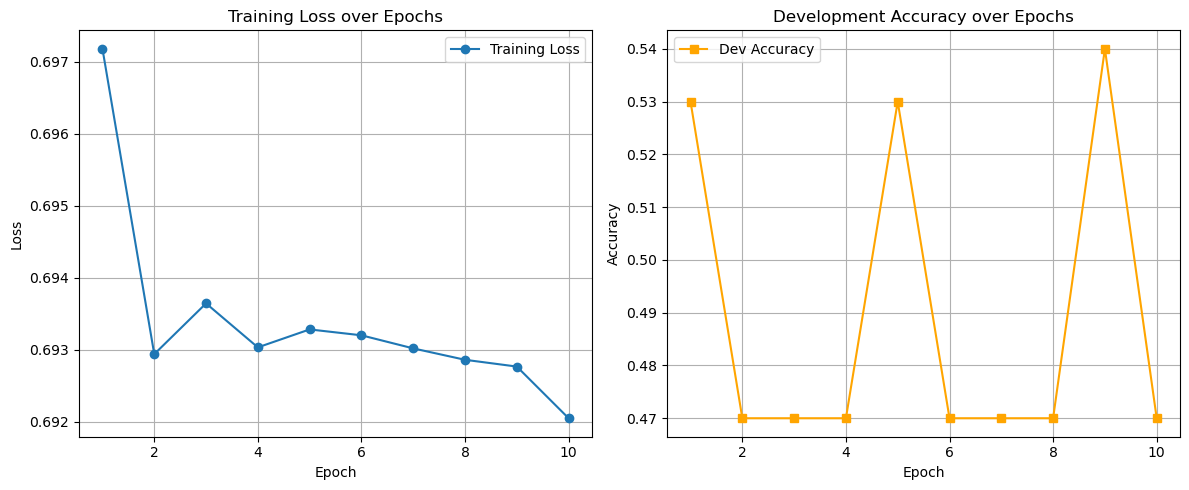

In [52]:
# %%
# Plot Training Loss and Development Accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Development Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), dev_accuracies, marker='s', color='orange', label='Dev Accuracy')
plt.title('Development Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
# %%
# Define the checkpoint path
checkpoint_path = 'best_ffn_model_multi_hot.pth'

# Save the best model
torch.save(best_model_state, checkpoint_path)
print(f"\nBest FFN model saved to {checkpoint_path}")



Best FFN model saved to best_ffn_model_multi_hot.pth


### RNNs

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import copy
import matplotlib.pyplot as plt

# %%
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, nonlinearity='tanh')

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Activation function
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Since multi-hot encoding is a single vector, treat seq_length=1
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, output_size)
        out = self.sigmoid(out).squeeze()

        return out



In [55]:
# %%
# Parameters for RNN
input_size_rnn = vocab_size  # 2000 (multi-hot encoded vector)
hidden_size_rnn = 256
output_size_rnn = 1  # Binary classification
num_layers_rnn = 1  # Number of RNN layers
dropout_rnn = 0.5  # Dropout probability (not applied since num_layers=1)
learning_rate_rnn = 0.005
num_epochs_rnn = 10

# Initialize the RNN model
rnn_model = SentimentRNN(input_size_rnn, hidden_size_rnn, output_size_rnn, num_layers_rnn, dropout_rnn)

# Move model to GPU if available
rnn_model.to(device)

# Define loss and optimizer
criterion_rnn = nn.BCELoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=learning_rate_rnn)

# Lists to store loss and accuracy for plotting
train_losses_rnn = []
dev_accuracies_rnn = []

best_dev_accuracy_rnn = 0.0
best_model_state_rnn = copy.deepcopy(rnn_model.state_dict())

for epoch in range(num_epochs_rnn):
    rnn_model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)  # [batch_size, vocab_size]
        batch_Y = batch_Y.to(device).float()  # [batch_size]

        # Reshape input for RNN: [batch_size, seq_length=1, input_size]
        batch_X = batch_X.unsqueeze(1)  # [batch_size, 1, vocab_size]

        # Forward pass
        outputs = rnn_model(batch_X)  # [batch_size]
        loss = criterion_rnn(outputs, batch_Y)

        # Backward and optimize
        optimizer_rnn.zero_grad()
        loss.backward()
        optimizer_rnn.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_rnn.append(epoch_loss)

    # Evaluation on development set
    rnn_model.eval()
    dev_preds = []
    dev_labels = []
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).float()
            batch_X = batch_X.unsqueeze(1)  # [batch_size, 1, vocab_size]
            outputs = rnn_model(batch_X)  # [batch_size]
            preds = (outputs >= 0.5).long()
            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(batch_Y.cpu().numpy())

    dev_accuracy = accuracy_score(dev_labels, dev_preds)
    dev_accuracies_rnn.append(dev_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs_rnn}], Loss: {epoch_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # Save the model if dev accuracy improves
    if dev_accuracy > best_dev_accuracy_rnn:
        best_dev_accuracy_rnn = dev_accuracy
        best_model_state_rnn = copy.deepcopy(rnn_model.state_dict())

# Load the best RNN model
rnn_model.load_state_dict(best_model_state_rnn)
print(f"\nBest RNN Dev Accuracy: {best_dev_accuracy_rnn:.4f}")


Epoch [1/10], Loss: 0.7184, Dev Accuracy: 0.5500
Epoch [2/10], Loss: 0.6958, Dev Accuracy: 0.5400
Epoch [3/10], Loss: 0.6932, Dev Accuracy: 0.4700
Epoch [4/10], Loss: 0.6928, Dev Accuracy: 0.5500
Epoch [5/10], Loss: 0.6949, Dev Accuracy: 0.5700
Epoch [6/10], Loss: 0.6984, Dev Accuracy: 0.4800
Epoch [7/10], Loss: 0.6925, Dev Accuracy: 0.5700
Epoch [8/10], Loss: 0.6911, Dev Accuracy: 0.5700
Epoch [9/10], Loss: 0.7104, Dev Accuracy: 0.5000
Epoch [10/10], Loss: 0.6970, Dev Accuracy: 0.5300

Best RNN Dev Accuracy: 0.5700


In [56]:
# %%
# Evaluation on Test Set for RNN
rnn_model.eval()
test_preds_rnn = []
test_labels_rnn = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).float()
        batch_X = batch_X.unsqueeze(1)  # [batch_size, 1, vocab_size]
        outputs = rnn_model(batch_X)  # [batch_size]
        preds = (outputs >= 0.5).long()
        test_preds_rnn.extend(preds.cpu().numpy())
        test_labels_rnn.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy_rnn = accuracy_score(test_labels_rnn, test_preds_rnn)
precision_rnn, recall_rnn, f1_rnn, _ = precision_recall_fscore_support(test_labels_rnn, test_preds_rnn, average='binary')

print(f"\nRNN Test Accuracy: {accuracy_rnn:.4f}")
print(f"RNN Test Precision: {precision_rnn:.4f}")
print(f"RNN Test Recall: {recall_rnn:.4f}")
print(f"RNN Test F1-Score: {f1_rnn:.4f}")

# Detailed metrics for each class
precision_per_class_rnn, recall_per_class_rnn, f1_per_class_rnn, _ = precision_recall_fscore_support(
    test_labels_rnn, test_preds_rnn, labels=[0, 1]
)

print("\nRNN Per Class Metrics:")
print(f"Class 0 - Precision: {precision_per_class_rnn[0]:.4f}, Recall: {recall_per_class_rnn[0]:.4f}, F1-Score: {f1_per_class_rnn[0]:.4f}")
print(f"Class 1 - Precision: {precision_per_class_rnn[1]:.4f}, Recall: {recall_per_class_rnn[1]:.4f}, F1-Score: {f1_per_class_rnn[1]:.4f}")



RNN Test Accuracy: 0.5380
RNN Test Precision: 0.5348
RNN Test Recall: 0.6262
RNN Test F1-Score: 0.5769

RNN Per Class Metrics:
Class 0 - Precision: 0.5426, Recall: 0.4487, F1-Score: 0.4912
Class 1 - Precision: 0.5348, Recall: 0.6262, F1-Score: 0.5769


In [60]:
# # Load the best model
# model.load_state_dict(best_model_state)
# print(f"\nBest Dev Accuracy: {best_dev_accuracy:.4f}")

# # Evaluation on Test Set
# model.eval()
# test_preds = []
# test_labels = []
# with torch.no_grad():
#     for batch_X, batch_Y in test_loader:
#         batch_X = batch_X.to(device)
#         batch_Y = batch_Y.to(device)
#         outputs = model(batch_X)  # [batch_size, output_size]
#         _, preds = torch.max(outputs, 1)  # [batch_size]
#         test_preds.extend(preds.cpu().numpy())
#         test_labels.extend(batch_Y.cpu().numpy())

# # Calculate metrics
# accuracy = accuracy_score(test_labels, test_preds)
# precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

# print(f"\nTest Accuracy: {accuracy:.4f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# print(f"Test F1-Score: {f1:.4f}")

# # Detailed metrics for each class
# precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
#     test_labels, test_preds, labels=[0, 1]
# )

# print("\nPer Class Metrics:")
# print(f"Class 0 - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1-Score: {f1_per_class[0]:.4f}")
# print(f"Class 1 - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1-Score: {f1_per_class[1]:.4f}")


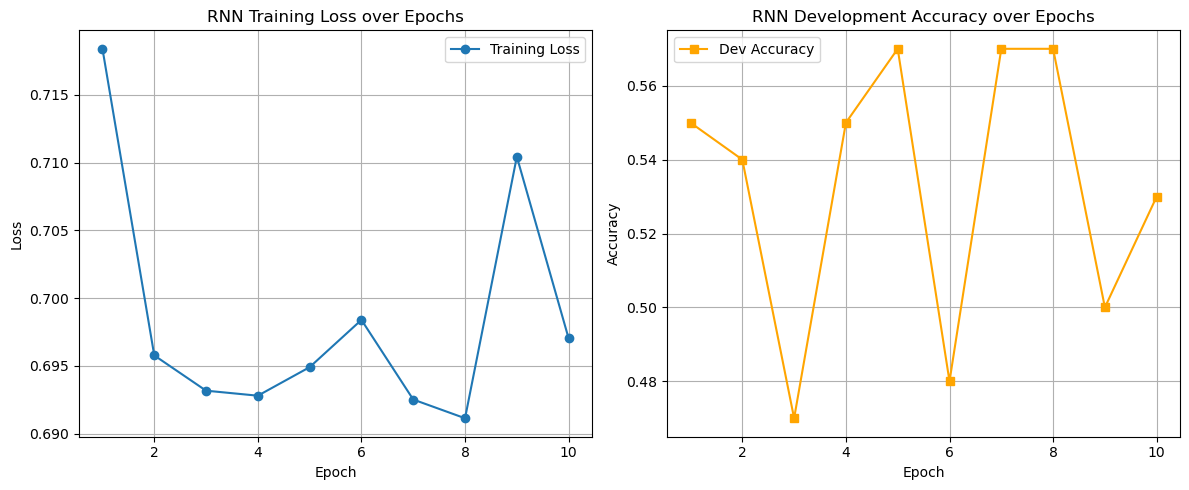

In [58]:
# %%
# Plot Training Loss and Development Accuracy for RNN
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_rnn + 1), train_losses_rnn, marker='o', label='Training Loss')
plt.title('RNN Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Development Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_rnn + 1), dev_accuracies_rnn, marker='s', color='orange', label='Dev Accuracy')
plt.title('RNN Development Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
# %%
# Define the checkpoint path for RNN
checkpoint_path_rnn = 'best_rnn_model_multi_hot.pth'

# Save the best RNN model
torch.save(best_model_state_rnn, checkpoint_path_rnn)
print(f"\nBest RNN model saved to {checkpoint_path_rnn}")



Best RNN model saved to best_rnn_model_multi_hot.pth
